## Roman HLTDS simulations
This notebook demonstrates how we can simulate the Roman High Latitude Time Domain Survey (HLTDS) using files exported from APT using [LightCurveLynx](https://lightcurvelynx.readthedocs.io/en/latest/). 

First we need install the APT version that supports Roman (we are using Version 2025.6.3) from https://apst.stsci.edu/apt/external/downloads/APT-2025.6.3/Web/install.html

Now let's export a "Simulator Input" ecsv file from APT which contains pointing and exposure information. This can be done by going to File->Export in APT and select Simulator Input as shown below. (The default export file name is 'unknown.sim.ecsv') <br> <img src="figs/APT.png" width="300" height="200">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
import pandas as pd
import sncosmo
from scipy import stats
from scipy.special import expit
from nested_pandas import read_parquet
from joblib import Parallel, delayed
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from regions import RectangleSkyRegion

from lightcurvelynx.obstable.roman_obstable import RomanObsTable
from lightcurvelynx.astro_utils.passbands import PassbandGroup
from lightcurvelynx.astro_utils.pzflow_node import PZFlowNode
from lightcurvelynx.astro_utils.snia_utils import (
    DistModFromRedshift,
    HostmassX1Func,
    X0FromDistMod,
    num_snia_per_redshift_bin,
)
from lightcurvelynx.math_nodes.scipy_random import SamplePDF
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc
from lightcurvelynx.simulate import simulate_lightcurves
from lightcurvelynx.models.sncosmo_models import SncosmoWrapperModel
from lightcurvelynx.models.snia_host import SNIaHost
from lightcurvelynx.utils.plotting import plot_lightcurves
from lightcurvelynx.math_nodes.ra_dec_sampler import ObsTableUniformRADECSampler,ApproximateMOCSampler
from lightcurvelynx.astro_utils.dustmap import DustmapWrapper,SFDMap
from lightcurvelynx.effects.extinction import ExtinctionEffect
from lightcurvelynx.astro_utils.mag_flux import mag2flux,flux2mag
from lightcurvelynx.utils.extrapolate import LinearFitOnMag,ZeroPadding
from lightcurvelynx.astro_utils.detector_footprint import DetectorFootprint

from lightcurvelynx import _LIGHTCURVELYNX_BASE_DATA_DIR

Now we define necessary information for the simulation. This includes an ObsTable, which is the ecsv file we just exported. For right now we only support photometry simulation, so we drop rows for PRISM and only focus on the photometry entries. We also define a PassbandGroup from loading a preset. We append the ObsTable when initializing the RomanObsTable class to include a time column based on the survey discription in https://roman.gsfc.nasa.gov/science/High_Latitude_Time_Domain_Survey.html, which is not currently provided in the file.

In [2]:
%%time
# Load the ecsv file.
fsim = 'roman_opsim/unknown.sim.ecsv'
with open(fsim,"r") as f:
    lines = f.read()
lines = lines.replace('no name','no_name')
apt_table = Table.read(lines, format="ascii.ecsv").to_pandas()

apt_table = apt_table.loc[apt_table.BANDPASS != "PRISM"]

# We use a rectangular detector footprint for approximation.
pixel_scale = 0.11 #arcsec/pixel
center = SkyCoord(ra=0.0, dec=0.0, unit="deg", frame="icrs")
#compute an angle based on ra/dec in the table
rect_region = RectangleSkyRegion(center=center, width=49.4/60. * u.deg, 
                                 height=25.3/60. *u.deg, angle= 0. * u.deg)
fp = DetectorFootprint(rect_region, pixel_scale=pixel_scale)

roman_obstable = RomanObsTable(apt_table,detector_footprint=fp)

t_min, t_max = roman_obstable.time_bounds()
print(f"Loaded ObsTable with {len(roman_obstable)} rows and times [{t_min}, {t_max}]")

passband_group = PassbandGroup.from_preset(preset="Roman")
print(f"Loaded Passbands: {passband_group}")

Loaded ObsTable with 47931 rows and times [61406.0, 63416.5]
Loaded Passbands: PassbandGroup containing 8 passbands: Roman_F062, Roman_F087, Roman_F106, Roman_F129, Roman_F146, Roman_F158, Roman_F184, Roman_F213
CPU times: user 2.06 s, sys: 48.7 ms, total: 2.1 s
Wall time: 2.29 s


If needed, we can overwrite the default values of the following attributes. We show the default values here.

In [3]:
print("Survey start time:", roman_obstable.survey_values["survey_start_time"])
print("Survey cadence:", roman_obstable.survey_values["cadence"])
print("Survey component start time:", roman_obstable.survey_values["component_start_time"])
print("After component delay time:", roman_obstable.survey_values["after_component_delay_time"])

Survey start time: 61406.0
Survey cadence: {'PC': 20.0, 'EC1': 120.0, 'EC2': 120.0, 'CC': 5.0}
Survey component start time: {'North': {'PC': 61406.0, 'EC1': 61666.0, 'CC': 62126.0, 'EC2': 62936.0}, 'South': {'PC': 61406.5, 'EC1': 61666.5, 'CC': 62126.5, 'EC2': 62936.5}}
After component delay time: {'PC': 100.0, 'EC1': 100.0, 'CC': 100.0}


We can overwrite the values as the below

In [4]:
roman_obstable.survey_values["survey_start_time"] = 61436.
roman_obstable.infer_component_start_time(after_component_delay_time={"PC": 10.,
                                                                      "EC1": 10.,
                                                                      "CC": 10.,})

We can update the time column using the new values

In [5]:
roman_obstable.update_time()
print("New survey start time:", roman_obstable.survey_values["survey_start_time"])
print("New survey cadence:", roman_obstable.survey_values["cadence"])
print("New survey component start time:", roman_obstable.survey_values["component_start_time"])
print("New after component delay time:", roman_obstable.survey_values["after_component_delay_time"])

New survey start time: 61436.0
New survey cadence: {'PC': 20.0, 'EC1': 120.0, 'EC2': 120.0, 'CC': 5.0}
New survey component start time: {'North': {'PC': 61436.0, 'EC1': 61606.0, 'CC': 61976.0, 'EC2': 62696.0}, 'South': {'PC': 61436.5, 'EC1': 61606.5, 'CC': 61976.5, 'EC2': 62696.5}}
New after component delay time: {'PC': 10.0, 'EC1': 10.0, 'CC': 10.0}


We can sample the RA and DEC using the regions covered by the obstable using a built-in RA/DEC sampler- ApproximateMOCSampler

In [6]:
moc = roman_obstable.build_moc(use_footprint=True,max_depth=15)
radec_node = ApproximateMOCSampler(moc, depth=15)

zmin = 0.1
zmax = 1.2
H0 = 70.0
Omega_m = 0.3
nsn, z = num_snia_per_redshift_bin(zmin, zmax, 100, H0=H0, Omega_m=Omega_m)
zpdf = interp1d(z, nsn, bounds_error=False, fill_value=0)

host = SNIaHost(
    ra = radec_node.ra,
    dec = radec_node.dec,
    hostmass=10.,
    redshift=SamplePDF(zpdf),
    node_label="host",
)

Evaluating Region: 100%|█████████████████████| 349/349 [00:01<00:00, 301.67it/s]


Now we define parameter distributions to sample from

In [7]:
t_min, t_max = roman_obstable.time_bounds()

distmod_func = DistModFromRedshift(host.redshift, H0=73.0, Omega_m=0.3)
m_abs_func = NumpyRandomFunc("normal", loc=-19., scale=0.1)
x0_func = X0FromDistMod(
    distmod=distmod_func,
    x1=NumpyRandomFunc("normal",loc=0, scale=0.2), 
    c=NumpyRandomFunc("normal",loc=0, scale=0.02),
    alpha=0.14,
    beta=3.1,
    m_abs=m_abs_func,
    node_label="x0_func",
)

sncosmo_modelname = "salt2-h17"
time_extrap_before = ZeroPadding()
time_extrap_after = LinearFitOnMag(nfit=20,binnum=1)
wave_extrap_before = ZeroPadding()
wave_extrap_after = ZeroPadding()
source = SncosmoWrapperModel(
    sncosmo_modelname,
    t0=NumpyRandomFunc("uniform", low=t_min, high=t_max),
    x0=x0_func,
    x1=x0_func.x1,
    c=x0_func.c,
    ra=host.ra,
    dec=host.dec,
    redshift=host.redshift,
    node_label="source",
    time_extrapolation=(time_extrap_before,time_extrap_after),
    wave_extrapolation=(wave_extrap_before,wave_extrap_after),
)
    
mwextinction = SFDMap(
    ra=source.ra,
    dec=source.dec,
    node_label="mwext",
)

# Create an extinction effect using the EBVs from that dust map.
ext_effect = ExtinctionEffect(extinction_model="F99", ebv=mwextinction, Rv=3.1,frame='observer')
source.add_effect(ext_effect)


Now let's simulate 500 SN Ia using the `simulate_lightcurves` function.

In [8]:
%%time
nsntotal = 500
print(nsntotal)
lightcurves = simulate_lightcurves(source, int(nsntotal), roman_obstable, passband_group)
lightcurves

500


Simulating: 100%|████████████████████████████| 500/500 [00:05<00:00, 95.00obj/s]


CPU times: user 7.7 s, sys: 436 ms, total: 8.13 s
Wall time: 8.15 s


id          ra        dec  nobs            t0         z  \
0      0  240.408832  54.109255   466  62047.396800  0.998053   
1      1  245.102637  53.848058   308  63133.405146  0.498590   
..   ...         ...        ...   ...           ...       ...   
498  498   59.201013 -50.263094  1447  62714.447256  0.767327   
499  499   62.912617 -46.598541     0  62321.541636  0.610426   

                                                params  \
0    {'ApproximateMOCSampler:uniform_2.ra': 240.408...   
1    {'ApproximateMOCSampler:uniform_2.ra': 245.102...   
..                                                 ...   
498  {'ApproximateMOCSampler:uniform_2.ra': 59.2010...   
499  {'ApproximateMOCSampler:uniform_2.ra': 62.9126...   

                                            lightcurve  
0    [{mjd: 61436.0, filter: 'F062', flux: 32.46736...  
1    [{mjd: 61436.0, filter: 'F106', flux: -16.1329...  
..                                                 ...  
498  [{mjd: 61436.5, filter: 'F106', flux: 18.15344...  
499                                               None  

[500 rows x 8 columns]

We can check the locations of the simulated SN against the pointings provided in the ObsTable

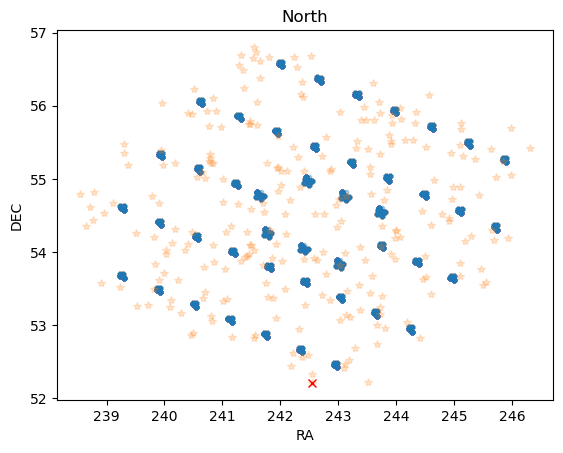

Text(0.5, 1.0, 'South')

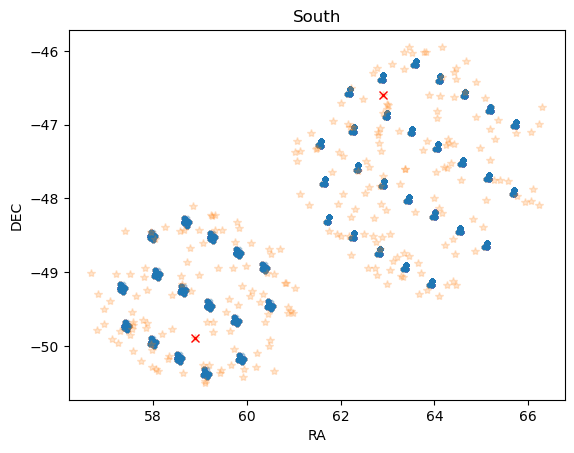

In [9]:
idx = lightcurves.lightcurve.isna()
north = apt_table.DEC > 0
north_sim = lightcurves.dec > 0
plt.plot(apt_table[north].RA,apt_table[north].DEC,'.',alpha=0.02)
plt.plot(lightcurves[north_sim].ra,lightcurves[north_sim].dec,"*",alpha=0.2)
plt.plot(lightcurves[north_sim & idx].ra,lightcurves[north_sim & idx].dec,"x",c='r')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('North')
plt.show()
south = apt_table.DEC < 0
south_sim = lightcurves.dec < 0
plt.plot(apt_table[south].RA,apt_table[south].DEC,'.',alpha=0.02)
plt.plot(lightcurves[south_sim].ra,lightcurves[south_sim].dec,"*",alpha=0.2)
plt.plot(lightcurves[south_sim & idx].ra,lightcurves[south_sim & idx].dec,"x",c='r')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('South')

In [10]:
lightcurves['params'][0].keys()

dict_keys(['ApproximateMOCSampler:uniform_2.ra', 'ApproximateMOCSampler:uniform_2.dec', 'host.ra', 'host.dec', 'host.redshift', 'host.t0', 'host.distance', 'host.hostmass', 'SamplePDF:_rvs_3.function_node_result', 'source.ra', 'source.dec', 'source.redshift', 'source.t0', 'source.distance', 'source.x0', 'source.x1', 'source.c', 'source.Rv', 'source.ebv', 'NumpyRandomFunc:uniform_4.low', 'NumpyRandomFunc:uniform_4.high', 'NumpyRandomFunc:uniform_4.function_node_result', 'DistModFromRedshift:_distmod_from_redshift_6.redshift', 'DistModFromRedshift:_distmod_from_redshift_6.function_node_result', 'x0_func.distmod', 'x0_func.x1', 'x0_func.c', 'x0_func.alpha', 'x0_func.beta', 'x0_func.m_abs', 'x0_func.function_node_result', 'NumpyRandomFunc:normal_7.loc', 'NumpyRandomFunc:normal_7.scale', 'NumpyRandomFunc:normal_7.function_node_result', 'NumpyRandomFunc:normal_8.loc', 'NumpyRandomFunc:normal_8.scale', 'NumpyRandomFunc:normal_8.function_node_result', 'NumpyRandomFunc:normal_9.loc', 'NumpyRand

In [11]:
lightcurves.lightcurve.isna().sum()

np.int64(3)

In [12]:
#apply detection and spec efficiency
lightcurves = lightcurves.dropna(subset=['lightcurve'])
print("Before applying detection: nsn=", len(lightcurves))
lightcurves['lightcurve.snr'] = lightcurves['lightcurve.flux']/lightcurves['lightcurve.fluxerr']
lightcurves_after_detection = lightcurves.query('lightcurve.snr > 5').dropna(subset=['lightcurve'])
print("After applying detection: nsn=", len(lightcurves_after_detection))

Before applying detection: nsn= 497
After applying detection: nsn= 358


/Users/mi/anaconda3/envs/lightcurvelynx/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().__setitem__(nested, new_nested_series)
/Users/mi/anaconda3/envs/lightcurvelynx/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:1349: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)


/var/folders/zs/zxl3t6ks12zg2l3dp9qn1rkr0000gn/T/ipykernel_4809/1851337517.py:24: RuntimeWarning: invalid value encountered in log10
  lc_mag = -2.5*np.log10(lc_flux) + 31.4


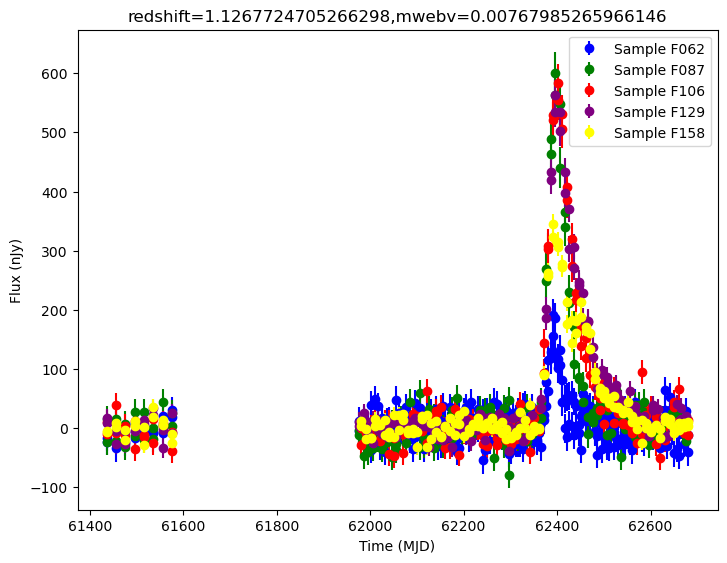

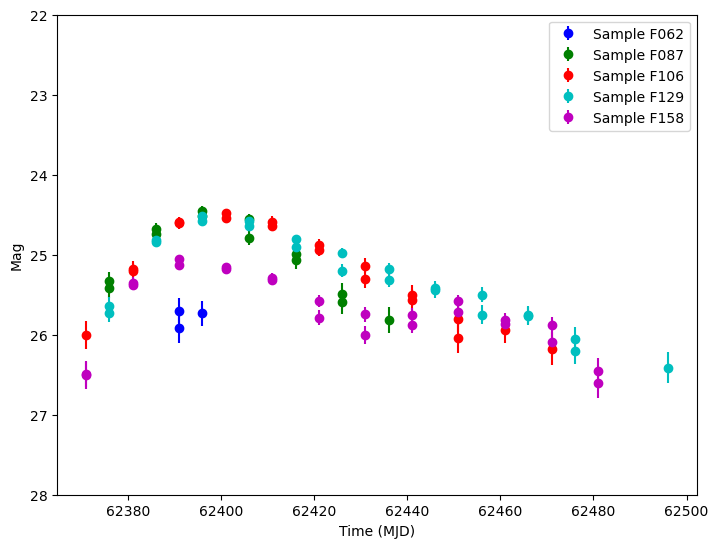

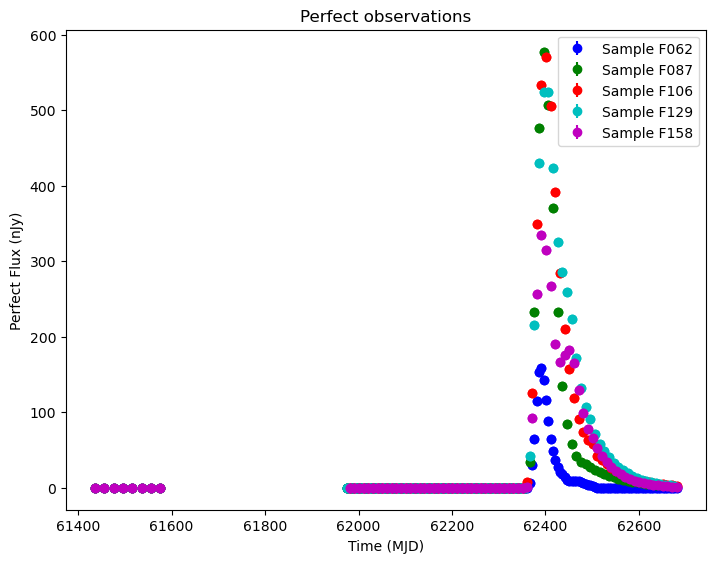

In [13]:
random_ids = lightcurves_after_detection.id.sample(1).values

colormap = {"F062":"blue",
            "F087":"green", 
            "F106":"red",
            "F129":"purple", 
            "F146":"cyan", 
            "F158":"yellow", 
            "F184":"gray", 
            "F213":"magenta",}

for random_id in random_ids:
    # Extract the row for this object.
    lc = lightcurves.loc[lightcurves.id==random_id]
    # lc = lightcurves_after_detection.loc[lightcurves_after_detection.id==random_id]
    
    if lc["nobs"].values[0] > 0:
        # Unpack the nested columns (filters, mjd, flux, and flux error).
        lc_filters = np.asarray(lc["lightcurve.filter"], dtype=str)
        lc_mjd = np.asarray(lc["lightcurve.mjd"], dtype=float)
        lc_flux = np.asarray(lc["lightcurve.flux"], dtype=float)
        lc_fluxerr = np.asarray(lc["lightcurve.fluxerr"], dtype=float)

        lc_mag = -2.5*np.log10(lc_flux) + 31.4
        lc_magerr = np.absolute(1.086*lc_fluxerr/lc_flux)

        lc_fluxperfect = np.asarray(lc["lightcurve.flux_perfect"])
        
        plot_lightcurves(
            fluxes=lc_flux,
            times=lc_mjd,
            fluxerrs=lc_fluxerr,
            filters=lc_filters,
            colormap=colormap,
        )
        plt.ylabel('Flux (nJy)')
        plt.title(f"redshift={lc['z'].values[0]},mwebv={lc['params'].values[0]['mwext.ebv']}")
        plt.show()

        detection = lc_magerr < 0.2
        plot_lightcurves(
            fluxes=lc_mag[detection],
            times=lc_mjd[detection],
            fluxerrs=lc_magerr[detection],
            filters=lc_filters[detection],
        )
        plt.ylabel('Mag')
        plt.ylim((28,22))
        plt.show()

        plot_lightcurves(
            fluxes=lc_fluxperfect,
            times=lc_mjd,
            fluxerrs=np.array([0.02]*len(lc_mjd)),
            filters=lc_filters,
        )
        plt.ylabel('Perfect Flux (nJy)')
        plt.title('Perfect observations')